# ML-SGD MAIN worker 2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/MLSGD/ex_data")

import matplotlib.pyplot as plt

import numpy as np
import torch
torch.manual_seed(0)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

# from scipy.stats import multivariate_normal
from copy import deepcopy
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# check GPU info
!/opt/bin/nvidia-smi
print(device)


Mounted at /content/drive
Wed Jan 19 17:45:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
import random, os
def seed_torch(seed=33):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
seed_torch()

In [ ]:
# define transforms
resize_32 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# import data
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=resize_32
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=resize_32
)

Nr = 10
batch_size = 16
batch_size = batch_size * Nr
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, worker_init_fn=torch.manual_seed(33))
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


Text(0.5, 1.0, '1')

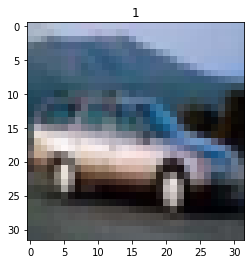

In [ ]:
img, label = training_data[4]
img1 = np.ndarray([32,32,3])
for i in range(3):
    img1[:,:,i] = img[i,:,:]

plt.imshow(img1)
plt.title(label)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = torch.nn.functional.softmax(logits, dim=1)
        return logits

# figure out what is probs

In [ ]:
N = 0
batch_size_mlsgd = batch_size // Nr
print(batch_size_mlsgd)
print(batch_size // batch_size_mlsgd)


for batch, (X, y) in enumerate(train_dataloader):
    print(batch)

    for i in range(batch_size // batch_size_mlsgd):
        XX = X[i*batch_size_mlsgd:(i+1)*batch_size_mlsgd]
        yy = y[i*batch_size_mlsgd:(i+1)*batch_size_mlsgd]
        print(yy)

    # print(X)
    print(y)
    N += 1
    if N == 1:
        break

16
10
0
tensor([0, 7, 1, 7, 9, 1, 9, 8, 2, 5, 9, 4, 0, 2, 5, 7])
tensor([5, 1, 7, 7, 7, 0, 6, 1, 4, 3, 0, 2, 9, 8, 5, 5])
tensor([8, 1, 2, 0, 1, 6, 4, 0, 1, 1, 5, 7, 2, 7, 1, 8])
tensor([7, 0, 0, 5, 6, 7, 8, 7, 8, 5, 2, 4, 5, 6, 9, 2])
tensor([8, 8, 7, 8, 4, 5, 6, 3, 1, 4, 0, 4, 8, 5, 0, 3])
tensor([6, 3, 7, 9, 9, 9, 1, 9, 5, 8, 7, 8, 9, 9, 8, 7])
tensor([4, 5, 6, 2, 5, 5, 2, 0, 7, 8, 5, 0, 9, 4, 1, 6])
tensor([6, 8, 0, 4, 2, 6, 1, 9, 5, 6, 8, 4, 0, 3, 2, 9])
tensor([9, 6, 8, 7, 7, 2, 8, 9, 5, 8, 9, 2, 0, 4, 0, 9])
tensor([9, 3, 9, 4, 7, 4, 4, 0, 8, 0, 9, 0, 0, 9, 5, 9])
tensor([0, 7, 1, 7, 9, 1, 9, 8, 2, 5, 9, 4, 0, 2, 5, 7, 5, 1, 7, 7, 7, 0, 6, 1,
        4, 3, 0, 2, 9, 8, 5, 5, 8, 1, 2, 0, 1, 6, 4, 0, 1, 1, 5, 7, 2, 7, 1, 8,
        7, 0, 0, 5, 6, 7, 8, 7, 8, 5, 2, 4, 5, 6, 9, 2, 8, 8, 7, 8, 4, 5, 6, 3,
        1, 4, 0, 4, 8, 5, 0, 3, 6, 3, 7, 9, 9, 9, 1, 9, 5, 8, 7, 8, 9, 9, 8, 7,
        4, 5, 6, 2, 5, 5, 2, 0, 7, 8, 5, 0, 9, 4, 1, 6, 6, 8, 0, 4, 2, 6, 1, 9,
        5, 6, 8, 4, 0,

In [ ]:
class GaussianPertubation(object):
    def __init__(self,std = 1.,device=device):
        self.std = std
        self.device = device
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w += torch.normal(0,self.std,w.shape,device=device)
            module.weight.data = w
        if hasattr(module, 'bias'):
            b = module.bias.data
            b += torch.normal(0,self.std,b.shape,device=device)
            module.bias.data = b

In [ ]:
model = LeNet5(10)
model.cuda()
nu = 1e2 * 1.6**10
GP = GaussianPertubation(std=1/nu)

for m in model.parameters():
    print(m[0])
    break

model.apply(GP)
for m in model.parameters():
    print(m[0])
    break


model.apply(GP)
for m in model.parameters():
    print(m[0])
    break

print(1.6 ** 10)

tensor([[[-6.9087e-02,  4.5489e-02,  3.1575e-02, -8.1948e-02,  7.4200e-02],
         [-6.0863e-02, -2.9971e-02,  9.6263e-02, -1.0777e-01,  5.0404e-02],
         [-1.0796e-01, -6.1882e-02, -7.0343e-02,  8.1653e-02,  1.5372e-02],
         [-5.7408e-02, -1.0465e-01,  4.5553e-02,  4.8515e-02,  4.7133e-03],
         [-3.0775e-02,  2.5680e-02,  1.0630e-01, -1.5986e-02,  9.0205e-02]],

        [[ 9.6120e-02,  4.4042e-02,  7.4594e-02, -1.3668e-02, -8.7156e-02],
         [-4.5614e-03,  7.3643e-06,  3.3617e-02, -1.0098e-01,  7.0700e-03],
         [ 4.4584e-02,  1.0270e-02, -8.2620e-02, -1.6470e-02, -8.4654e-02],
         [-1.5781e-02, -1.3366e-02, -7.6450e-03,  1.0797e-01,  2.6048e-04],
         [ 1.8904e-02,  6.7374e-02,  4.6198e-02, -9.4938e-02,  6.4232e-02]],

        [[-5.3348e-02,  1.1316e-01, -4.3093e-03,  2.2980e-02, -9.5287e-02],
         [-1.3857e-02, -2.4441e-02,  8.1819e-03, -4.1158e-02,  7.4328e-02],
         [-1.0321e-01,  1.0983e-01,  8.2687e-02, -6.9116e-02,  2.7584e-02],
        

In [ ]:
from copy import deepcopy

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        X = X.cuda()
        y = y.cuda()

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train_loop_MLSGD_fixed(dataloader, model, loss_fn, lr, Nr, nu):

    size = len(dataloader.dataset)
    GP = GaussianPertubation(std=1/nu)

    for batch, (X, y) in enumerate(dataloader):

        X = X.cuda()
        y = y.cuda()

        model_fix = deepcopy(model)

        for ind in range(Nr):
            model_rand = deepcopy(model_fix)
            model_rand.apply(GP)

            pred = model_rand(X)
            loss = loss_fn(pred, y)
            loss.backward()

            count = 0
            for p in model.parameters():
                p.data -= lr * list(model_rand.parameters())[count].grad.data
                # p.data -= lr * list(model_rand.parameters())[count].grad.data / Nr
                count += 1

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train_loop_MLSGD(dataloader, model, loss_fn, lr, Nr, batch_size, nu):

    size = len(dataloader.dataset)
    GP = GaussianPertubation(std=1/nu)

    batch_size_mlsgd = batch_size // Nr

    for batch, (X, y) in enumerate(dataloader):

        X = X.cuda()
        y = y.cuda()

        # model: the main updated model, all updates on model
        # model_fix: save the model at the beginning of each iteration
        # model_rand: evaluate the loss and gradient for the Gaussian perturbated model

        model_fix = deepcopy(model)

        for i in range(batch_size // batch_size_mlsgd):
            XX = X[i*batch_size_mlsgd:(i+1)*batch_size_mlsgd]
            yy = y[i*batch_size_mlsgd:(i+1)*batch_size_mlsgd]

            # deepcopy and apply Gaussian perturbation
            model_rand = deepcopy(model_fix)
            model_rand.apply(GP)

            # evaluate loss and gradient
            pred = model_rand(XX)
            loss = loss_fn(pred, yy)
            loss.backward()

            count = 0
            for p in model.parameters():
                p.data -= lr * list(model_rand.parameters())[count].grad.data
                count += 1

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop_cuda(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [ ]:
print('batch size: ', batch_size)

batch size:  160


## Training NN

batch_size:  16
Nr:  10
nu =  800
rho =  1
Test Error: 
 Accuracy: 10.2%, Avg loss: 2.307298 

Epoch 1
-------------------------------
loss: 2.308937  [    0/50000]
loss: 2.244109  [16000/50000]
loss: 2.087219  [32000/50000]
loss: 1.718348  [48000/50000]
Epoch 2
-------------------------------
loss: 1.884714  [    0/50000]
loss: 1.750964  [16000/50000]
loss: 1.944033  [32000/50000]
loss: 1.853067  [48000/50000]
Epoch 3
-------------------------------
loss: 1.978785  [    0/50000]
loss: 1.619598  [16000/50000]
loss: 1.573739  [32000/50000]
loss: 1.847487  [48000/50000]
Epoch 4
-------------------------------
loss: 1.635209  [    0/50000]
loss: 2.060882  [16000/50000]
loss: 1.461414  [32000/50000]
loss: 1.752042  [48000/50000]
Epoch 5
-------------------------------
loss: 1.242077  [    0/50000]
loss: 1.265465  [16000/50000]
loss: 1.522411  [32000/50000]
loss: 1.420921  [48000/50000]
Epoch 6
-------------------------------
loss: 1.477465  [    0/50000]
loss: 1.650939  [16000/50000]
loss:

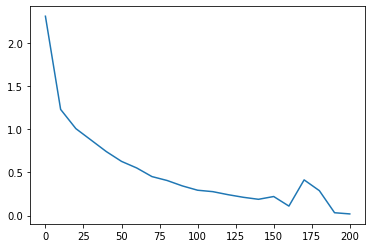

In [ ]:
seed_torch()

# model = torch.load('model_adam_20epoch.pth')
model = LeNet5(10)
model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.cuda()

learning_rate = 1e-2
nu = 800
epochs = 200
Nr = 10
rho = 1

print('batch_size: ', batch_size // Nr)
print('Nr: ', Nr)
print('nu = ', nu)
print('rho = ', rho)

# record
loss_vals = []
loss_val, accuracy_val = test_loop_cuda(train_dataloader, model, loss_fn)
loss_vals.append(loss_val)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop_MLSGD(train_dataloader, model, loss_fn, learning_rate, Nr, batch_size, nu)

    if np.remainder(t+1, 10) == 0:
        loss_val, accuracy_val = test_loop_cuda(train_dataloader, model, loss_fn)
        loss_vals.append(loss_val)
        nu = rho * nu // 1
        print("nu = ", nu)

print("Done!")

epochs = np.linspace(0,epochs,len(loss_vals))
plt.plot(epochs, loss_vals)
np.save("lenet5_mlsgd_nu_800_rho_1_Nr_10_bs_16_lr_1e-2.npy", loss_vals)

In [ ]:
# 试试batch = 32
# 每隔10epoch保存一下模型


337.0